This is just a gentle introduction to NLP.

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
FAKE = pd.read_csv("DataSet_Misinfo_FAKE.csv")
TRUE = pd.read_csv("DataSet_Misinfo_TRUE.csv")

In [4]:
FAKE.drop("Unnamed: 0", axis=1, inplace=True)
TRUE.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
FAKE["IS_FAKE"] = 1
TRUE["IS_FAKE"] = 0

In [6]:
news = pd.concat([FAKE.sample(random_state=42, n=12000), TRUE.sample(random_state=42, n=12000)], ignore_index=True)

In [7]:
df = news.copy()

In [8]:
df.dropna(how="any", inplace=True)

In [9]:
df.columns = [col.upper() for col in df.columns]
df["TEXT"] = df["TEXT"].str.lower()

In [10]:
## Getting rid of punctuations and digits
df["TEXT"] = df["TEXT"].str.replace("[^\w\s]", "")
df["TEXT"] = df["TEXT"].str.replace("\d", "")

In [11]:
## Stop words
sw = stopwords.words('english')
df["TEXT"] = df["TEXT"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [12]:
## Rare words
temp_df = pd.Series(' '.join(df["TEXT"]).split()).value_counts()
drops = temp_df[temp_df <= 10]
df["TEXT"] = df["TEXT"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [13]:
## Lemmatization
df["TEXT"] = df["TEXT"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

(-0.5, 399.5, 199.5, -0.5)

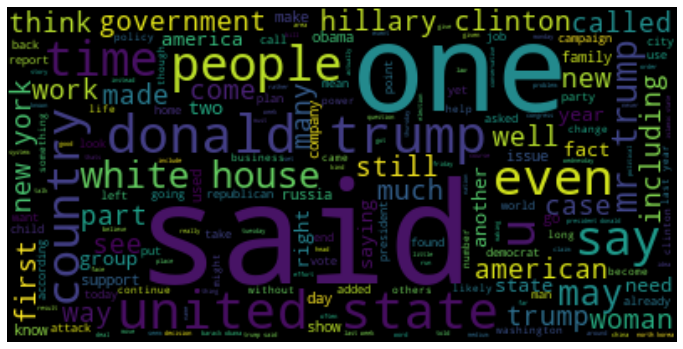

In [14]:
text = " ".join(i for i in df.TEXT)

plt.figure(figsize=(12,10))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["TEXT"]
y = df["IS_FAKE"]

In [16]:
## Term-frequency and inverse document frequency. Process of creating the matrix is as follows:
## TF (term frequency) = specific word's (t) frequency / number of words in the text
## IDF (inverse document frequency) = 1 + log_e((total document number + 1) / (number of documents that include t))
## TF * IDF
## L2 Normalization

tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [17]:
mNB = MultinomialNB()

In [18]:
## 5 fold cross-validation
cv_results = cross_validate(mNB,
                            X_tf_idf_word, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall"])

In [19]:
accuracy_score = cv_results['test_accuracy'].mean()
recall_score = cv_results['test_precision'].mean()
precision_score = cv_results['test_recall'].mean()

In [20]:
print(f"Accuracy: {round(accuracy_score, 3)}")
print(f"Recall: {round(recall_score,3)}")
print(f"Precision: {round(precision_score, 3)}")

Accuracy: 0.862
Recall: 0.869
Precision: 0.853


In [21]:
lr = LogisticRegression().fit(X_tf_idf_word, y)

In [22]:
## 5 fold cross-validation
cv_results = cross_validate(lr,
                            X_tf_idf_word, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall"])

In [23]:
accuracy_score = cv_results['test_accuracy'].mean()
recall_score = cv_results['test_precision'].mean()
precision_score = cv_results['test_recall'].mean()

In [24]:
print(f"Accuracy: {round(accuracy_score, 3)}")
print(f"Recall: {round(recall_score,3)}")
print(f"Precision: {round(precision_score, 3)}")

Accuracy: 0.925
Recall: 0.917
Precision: 0.934


In [25]:
rf = RandomForestClassifier(random_state=17)

In [26]:
## 5 fold cross-validation
cv_results = cross_validate(rf,
                            X_tf_idf_word, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall"])

In [27]:
accuracy_score = cv_results['test_accuracy'].mean()
recall_score = cv_results['test_precision'].mean()
precision_score = cv_results['test_recall'].mean()

In [28]:
print(f"Accuracy: {round(accuracy_score, 3)}")
print(f"Recall: {round(recall_score,3)}")
print(f"Precision: {round(precision_score, 3)}")

Accuracy: 0.912
Recall: 0.929
Precision: 0.891


In [29]:
rf_params = {"max_depth": [5, 8, None],
             "min_samples_split": [15, 20, 25],
             "n_estimators": [100, 200, 500]}

In [30]:
rf_best_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=True).fit(X_tf_idf_word, y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [32]:
rf_final = rf.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_tf_idf_word, y)

In [33]:
cv_results = cross_validate(rf_final,
                            X_tf_idf_word, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall"])

In [34]:
accuracy_score = cv_results['test_accuracy'].mean()
recall_score = cv_results['test_precision'].mean()
precision_score = cv_results['test_recall'].mean()

In [35]:
print(f"Accuracy: {round(accuracy_score, 3)}")
print(f"Recall: {round(recall_score,3)}")
print(f"Precision: {round(precision_score, 3)}")

Accuracy: 0.919
Recall: 0.936
Precision: 0.899
